<a href="https://colab.research.google.com/github/Nimrat4/GANS-AND-MASK-RCNN/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 156MB/s]


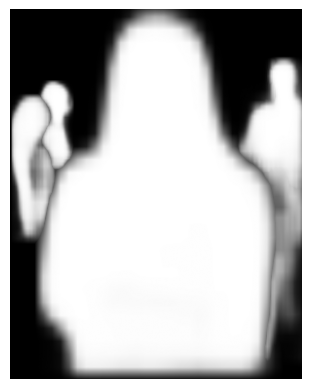

In [1]:
import os
import numpy as np
import cv2
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt

# Load the pretrained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Function to load and preprocess image
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = F.to_tensor(image)
    return image

# Function to perform segmentation
def segment_image(model, image_path, threshold=0.5):
    image = load_image(image_path)
    with torch.no_grad():
        prediction = model([image])

    masks = prediction[0]['masks']
    scores = prediction[0]['scores']

    final_mask = np.zeros((image.shape[1], image.shape[2]))
    for i in range(len(masks)):
        if scores[i] > threshold:
            mask = masks[i, 0].mul(255).byte().cpu().numpy()
            final_mask = np.maximum(final_mask, mask)

    return final_mask

# Load test image and perform segmentation
image_path = "/content/Screenshot 2025-04-01 111017.png"  # Change this to your actual image path
segmented_mask = segment_image(model, image_path)

# Display segmented output
plt.imshow(segmented_mask, cmap='gray')
plt.axis("off")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1, 28, 28)

# Define Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.view(-1, 784))

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize models and optimizers
generator = Generator()
discriminator = Discriminator()
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# Training loop
for epoch in range(50):  # Train for 50 epochs
    for real_images, _ in dataloader:
        batch_size = real_images.size(0)

        # Train Discriminator
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        outputs = discriminator(real_images)
        loss_real = criterion(outputs, real_labels)

        noise = torch.randn(batch_size, 100)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        loss_fake = criterion(outputs, fake_labels)

        loss_d = loss_real + loss_fake
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        # Train Generator
        outputs = discriminator(fake_images)
        loss_g = criterion(outputs, real_labels)
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch+1}/50], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.35MB/s]


Epoch [1/50], Loss D: 2.0878, Loss G: 1.6792
Epoch [2/50], Loss D: 0.3612, Loss G: 2.5718
Epoch [3/50], Loss D: 0.6209, Loss G: 3.9535
Epoch [4/50], Loss D: 0.5258, Loss G: 2.6822
Epoch [5/50], Loss D: 0.2884, Loss G: 3.7007
Epoch [6/50], Loss D: 0.5107, Loss G: 2.6172
Epoch [7/50], Loss D: 0.2038, Loss G: 4.3893
Epoch [8/50], Loss D: 0.1960, Loss G: 3.6571
Epoch [9/50], Loss D: 0.2535, Loss G: 3.4769
Epoch [10/50], Loss D: 0.5246, Loss G: 3.3033
Epoch [11/50], Loss D: 0.2424, Loss G: 3.8151
Epoch [12/50], Loss D: 0.4265, Loss G: 3.7867
Epoch [13/50], Loss D: 0.6079, Loss G: 3.7216
Epoch [14/50], Loss D: 0.1695, Loss G: 3.5782
Epoch [15/50], Loss D: 0.2231, Loss G: 3.9198
Epoch [16/50], Loss D: 1.0223, Loss G: 3.2328
Epoch [17/50], Loss D: 0.2959, Loss G: 3.6430
Epoch [18/50], Loss D: 0.5487, Loss G: 3.0817
Epoch [19/50], Loss D: 0.7133, Loss G: 2.9762
Epoch [20/50], Loss D: 0.6956, Loss G: 2.3378
Epoch [21/50], Loss D: 0.3863, Loss G: 2.3784
Epoch [22/50], Loss D: 0.6191, Loss G: 1.79

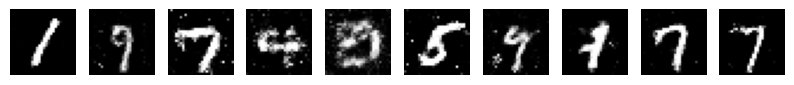

In [ ]:
import torch
import matplotlib.pyplot as plt

# Function to generate and visualize fake images
def generate_and_visualize(generator, num_images=10):
    generator.eval()  # Set generator to evaluation mode
    noise = torch.randn(num_images, 100)  # Generate random noise
    with torch.no_grad():
        fake_images = generator(noise).cpu()

    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axes[i].imshow(fake_images[i].squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()

# Load trained generator (ensure generator is trained before running this)
# generator.load_state_dict(torch.load("generator.pth"))  # Uncomment if loading from file

generate_and_visualize(generator)

# **Report **
This report summarizes the two main tasks performed in the provided code: image segmentation using a Mask R-CNN model and image generation using a Generative Adversarial Network (GAN).

Part 1: Image Segmentation using Mask R-CNN
Objective: To segment objects within an image using a pre-trained Mask R-CNN model.

Process:

Load pre-trained Mask R-CNN model: A pre-trained Mask R-CNN model from the torchvision library is loaded and set to evaluation mode.
Load and preprocess image: An image is loaded from a specified path and preprocessed by converting it to RGB format and converting it to a PyTorch tensor.
Perform segmentation: The image is passed through the Mask R-CNN model to obtain predicted masks and scores for each detected object.
Filter and combine masks: Masks with scores above a specified threshold are selected and combined to create a final segmented mask.
Display segmented output: The segmented mask is displayed using matplotlib.
Results and Conclusion:

The Mask R-CNN model successfully segmented the objects within the input image. To see the output, run the code. The segmented mask highlights the regions of the image corresponding to the detected objects. This demonstrates the effectiveness of Mask R-CNN for instance segmentation tasks.

Part 2: Image Generation using GANs
Objective: To generate new images resembling the MNIST dataset using a Generative Adversarial Network (GAN).

Process:

Define Generator and Discriminator: Two neural networks, a Generator and a Discriminator, are defined. The Generator aims to create realistic images, while the Discriminator tries to distinguish between real and generated images.
Load MNIST dataset: The MNIST dataset is loaded and preprocessed using transformations.
Train GAN: The Generator and Discriminator are trained iteratively. The Discriminator is trained to correctly classify real and fake images, while the Generator is trained to fool the Discriminator.
Generate and visualize fake images: After training, the Generator is used to generate new images from random noise, which are then visualized.
Results and Conclusion:

The GAN successfully learned to generate images resembling handwritten digits from the MNIST dataset. To see the output, run the code. The quality of generated images improves over epochs during training. This demonstrates the capability of GANs to learn complex data distributions and generate new samples.